<a href="https://colab.research.google.com/github/Laaliji/Image_processing_and_computer_vision_workshops/blob/main/spatial_filtering_fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running Spatial Filtering Lab...
Part 1: 2D Convolution


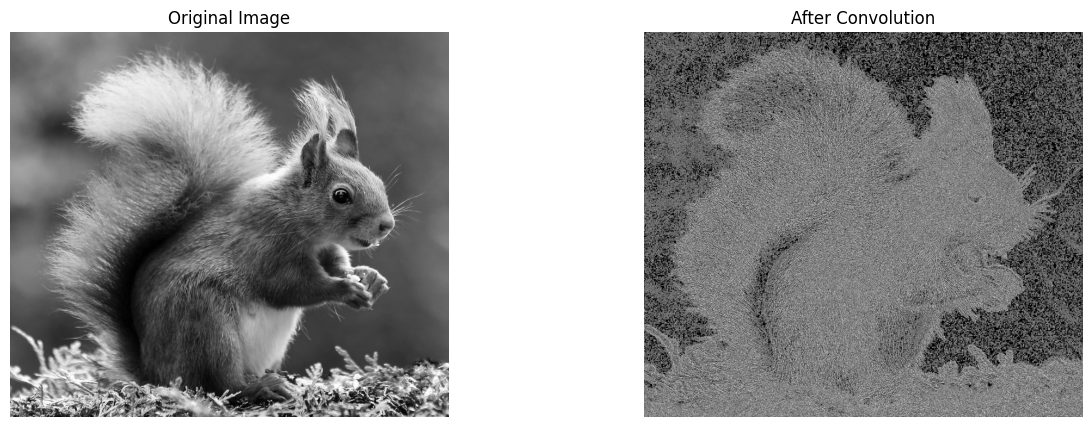

Part 2: Linear Filtering


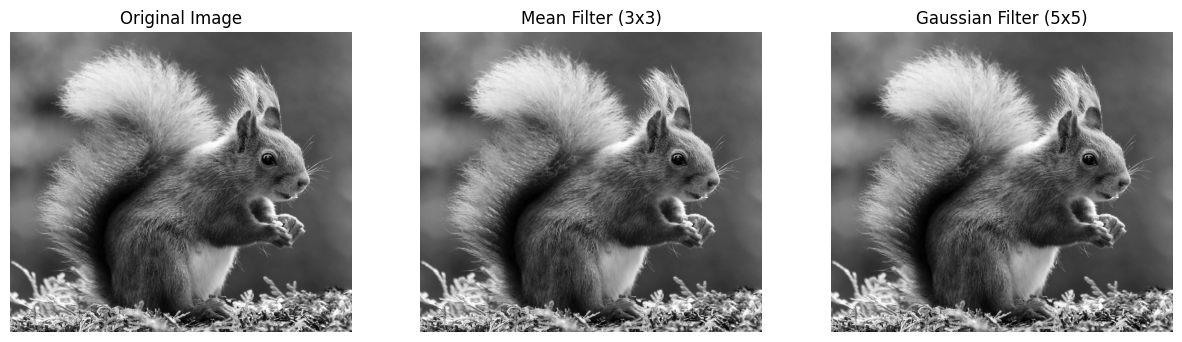

Part 3: Nonlinear Filtering


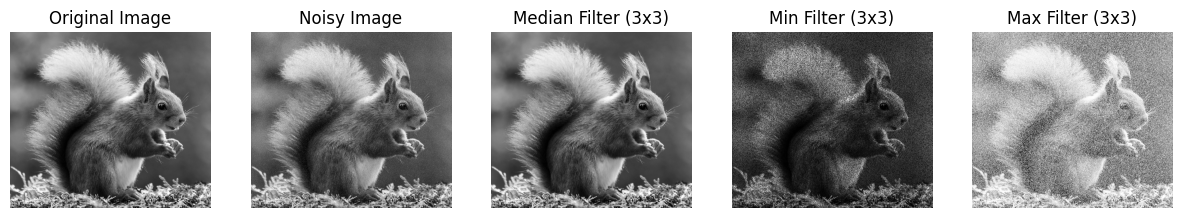

Part 4: Nagao Filter


In [ ]:
# Lab: Spatial Filtering in Image Processing
# This lab demonstrates spatial filtering techniques from Chapter 4, including:
# - 2D Convolution
# - Linear Filters: Mean and Gaussian
# - Nonlinear Filters: Median, Min/Max, and Nagao
# We use OpenCV, NumPy, and Matplotlib for processing and visualization.

import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

# Set random seed for reproducibility
np.random.seed(42)

# Function to load and preprocess user image
def load_image(image_path):
    """
    Load an image from the given path and convert to grayscale.
    Args:
        image_path: Path to the image file.
    Returns:
        Grayscale image as a numpy array, or synthetic image if loading fails.
    """
    try:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise FileNotFoundError("Image could not be loaded.")
        return image
    except Exception as e:
        print(f"Error loading image: {e}. Using synthetic image instead.")
        # Fallback synthetic image
        image = np.zeros((100, 100), dtype=np.uint8)
        image[20:80, 20:80] = 128
        image[40:60, 40:60] = 255
        return image

# Function to display images
def display_images(images, titles, cmap='gray'):
    """
    Display a list of images with titles.
    Args:
        images: List of images (numpy arrays).
        titles: List of titles for each image.
        cmap: Colormap for displaying images (default: 'gray').
    """
    plt.figure(figsize=(15, 5))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img, cmap=cmap)
        plt.title(title)
        plt.axis('off')
    plt.show()

# Part 1: 2D Convolution
def demonstrate_convolution(image):
    """
    Demonstrate 2D convolution with a custom kernel.
    Args:
        image: Input grayscale image.
    """
    # Define a 3x3 edge detection kernel
    kernel = np.array([[-1, -1, -1],
                       [-1,  8, -1],
                       [-1, -1, -1]])

    # Apply convolution
    convolved = convolve(image, kernel, mode='constant', cval=0.0)

    # Clip values to valid range for display
    convolved = np.clip(convolved, 0, 255).astype(np.uint8)

    # Display original and convolved images
    display_images([image, convolved], ['Original Image', 'After Convolution'])

# Part 2: Linear Filtering
def linear_filtering(image):
    """
    Demonstrate linear spatial filters: Mean and Gaussian.
    Args:
        image: Input grayscale image.
    """
    # Mean filter (3x3)
    mean_filtered = cv2.blur(image, (3, 3))

    # Gaussian filter (5x5, sigma=1)
    gaussian_filtered = cv2.GaussianBlur(image, (5, 5), sigmaX=1)

    # Display results
    display_images([image, mean_filtered, gaussian_filtered],
                   ['Original Image', 'Mean Filter (3x3)', 'Gaussian Filter (5x5)'])

# Part 3: Nonlinear Filtering
def nonlinear_filtering(image):
    """
    Demonstrate nonlinear spatial filters: Median, Min, Max.
    Args:
        image: Input grayscale image.
    """
    # Create noisy version of the image
    noisy_image = image.copy()
    # Add salt-and-pepper noise (5% salt, 5% pepper, 90% unchanged)
    noise_mask = np.random.choice([0, 1, 2], size=image.shape, p=[0.05, 0.05, 0.90])
    noisy_image[noise_mask == 0] = 0    # Pepper noise
    noisy_image[noise_mask == 1] = 255  # Salt noise

    # Median filter (3x3)
    median_filtered = cv2.medianBlur(noisy_image, 3)

    # Min filter (3x3)
    kernel = np.ones((3, 3), np.uint8)
    min_filtered = cv2.erode(noisy_image, kernel)

    # Max filter (3x3)
    max_filtered = cv2.dilate(noisy_image, kernel)

    # Display results
    display_images([image, noisy_image, median_filtered, min_filtered, max_filtered],
                   ['Original Image', 'Noisy Image', 'Median Filter (3x3)',
                    'Min Filter (3x3)', 'Max Filter (3x3)'])

# Part 4: Nagao Filter (Simplified)
def nagao_filter(image, window_size=5):
    """
    Implement a simplified Nagao filter by selecting the mean of the sub-window
    with the smallest variance.
    Args:
        image: Input grayscale image.
        window_size: Size of the window (default: 5).
    Returns:
        Filtered image.
    """
    # Pad the image to handle borders
    pad_size = window_size // 2
    padded = cv2.copyMakeBorder(image, pad_size, pad_size, pad_size, pad_size,
                                cv2.BORDER_REFLECT)
    output = np.zeros_like(image, dtype=np.float32)

    # Define directional sub-windows (simplified to 4 directions)
    offsets = [
        ([0, 0, 0, -1, -1, -1, -2, -2, -2], [0, -1, -2, 0, -1, -2, 0, -1, -2]),  # Top
        ([0, 0, 0, 1, 1, 1, 2, 2, 2], [0, -1, -2, 0, -1, -2, 0, -1, -2]),        # Bottom
        ([0, -1, -2, 0, -1, -2, 0, -1, -2], [0, 0, 0, -1, -1, -1, -2, -2, -2]),  # Left
        ([0, -1, -2, 0, -1, -2, 0, -1, -2], [0, 0, 0, 1, 1, 1, 2, 2, 2]),        # Right
    ]

    # Process each pixel
    for i in range(pad_size, padded.shape[0] - pad_size):
        for j in range(pad_size, padded.shape[1] - pad_size):
            variances = []
            means = []
            # Evaluate each directional window
            for dy, dx in offsets:
                window = []
                for k in range(len(dy)):
                    window.append(padded[i + dy[k], j + dx[k]])
                window = np.array(window)
                variances.append(np.var(window))
                means.append(np.mean(window))
            # Select mean of window with minimum variance
            min_var_idx = np.argmin(variances)
            output[i - pad_size, j - pad_size] = means[min_var_idx]

    return np.clip(output, 0, 255).astype(np.uint8)

def demonstrate_nagao(image):
    """
    Demonstrate the Nagao filter on a noisy image.
    Args:
        image: Input grayscale image.
    """
    # Create noisy version of the image
    noisy_image = image.copy()
    # Add salt-and-pepper noise (5% salt, 5% pepper, 90% unchanged)
    noise_mask = np.random.choice([0, 1, 2], size=image.shape, p=[0.05, 0.05, 0.90])
    noisy_image[noise_mask == 0] = 0    # Pepper noise
    noisy_image[noise_mask == 1] = 255  # Salt noise

    # Apply Nagao filter
    nagao_filtered = nagao_filter(noisy_image, window_size=5)

    # Display results
    display_images([image, noisy_image, nagao_filtered],
                   ['Original Image', 'Noisy Image', 'Nagao Filter'])

# Main function to run the lab
def main(image_path):
    """
    Run all demonstrations for the spatial filtering lab with a user-provided image.
    Args:
        image_path: Path to the input image.
    """
    # Load the image
    image = load_image(image_path)
    print("Running Spatial Filtering Lab...")

    print("Part 1: 2D Convolution")
    demonstrate_convolution(image)

    print("Part 2: Linear Filtering")
    linear_filtering(image)

    print("Part 3: Nonlinear Filtering")
    nonlinear_filtering(image)

    print("Part 4: Nagao Filter")
    demonstrate_nagao(image)

    print("Lab completed!")

if __name__ == "__main__":
    # Specify your image path here
    image_path = "immg.jpg"  # Replace with your image path, e.g., "my_image.png"
    main(image_path)